# Linear Elasticity Fracture Mechanics

*Authors: Laura De Lorenzis (ETH Zürich) and Corrado Maurini (corrado.maurini@sorbonne-universite.fr)*

This notebook serves as a tutorial for linear elastic fracture mechanics


In [1]:
%config Completer.use_jedi = False
%config IPCompleter.greedy = True

import matplotlib.pyplot as plt
import numpy as np

import dolfinx
import ufl

from mpi4py import MPI
from petsc4py import PETSc

import elastic_solver

from utils import project


# Asymptotic field and SIF ($K_I$)

Let us first get the elastic solution for a given crack length 

In [2]:
Lcrack = 0.3
Lx = 1.
uh, energy = elastic_solver.solve_elasticity(Lx=Lx,Ly=.5,Lcrack=Lcrack,lc=.05,refinement_ratio=30,dist_min=.2,dist_max=.3)

#plt.colorbar(dolfinx.plotting.plot(uh,mode="displacement"),orientation="horizontal")
#plt.title('Elastic solver - displacement field')



  return array(obj, copy=False)



Crack length: 3.000e-01 - Potential energy: -4.107e-03


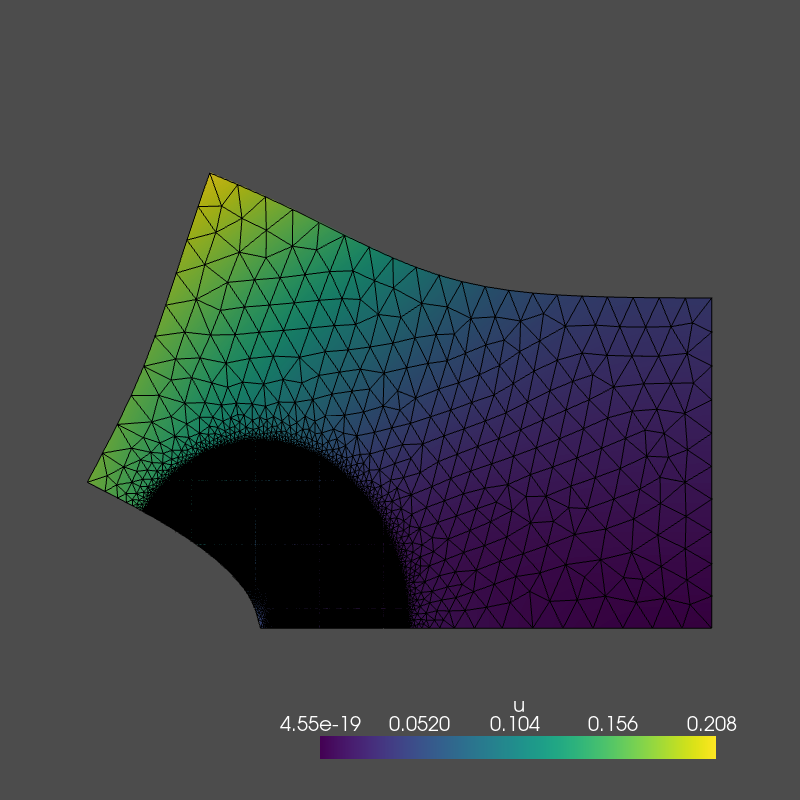

In [3]:
import pyvista
import dolfinx.plot
# Start virtual framebuffer
from pyvista.utilities.xvfb import start_xvfb
start_xvfb(wait=0)

mesh = uh.function_space.mesh
# Create plotter and pyvista grid
p = pyvista.Plotter(title="Deflection", window_size=[800, 800])
topology, cell_types = dolfinx.plot.create_vtk_topology(mesh, mesh.topology.dim)
grid = pyvista.UnstructuredGrid(topology, cell_types, mesh.geometry.x)

# Attach vector values to grid and warp grid by vector
vals_2D = uh.compute_point_values().real 
vals = np.zeros((vals_2D.shape[0], 3))
vals[:,:2] = vals_2D
grid["u"] = vals
#actor_0 = p.add_mesh(grid, style="wireframe", color="k")
warped = grid.warp_by_vector("u", factor=1.5)
actor_1 = p.add_mesh(warped, show_edges=True)
p.view_xy()
if not pyvista.OFF_SCREEN:
   p.show()
fig_array = p.screenshot(f"output/displacement.png")

## Crack opening displacement (COD)

Let us get the vertical displacement at the crack lip

In [4]:
mesh = uh.function_space.mesh
bottom_nodes = np.where(mesh.geometry.x[:,1] == 0)
xs = mesh.geometry.x[bottom_nodes,0][0]
us = uh.compute_point_values()[bottom_nodes,1][0]

Text(0.5, 1.0, 'Crack opening displacement')

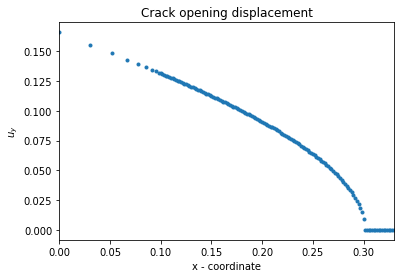

In [5]:
plt.plot(xs,us,".")
plt.xlim([0.,1.1*Lcrack])
plt.xlabel("x - coordinate")
plt.ylabel(r"$u_y$")
plt.title("Crack opening displacement")

As detailed in the lectures notes, we can estimate the value of the stress intensity factor $K_I$ by extrapolating $u \sqrt{2\pi/ r}$

  plt.semilogx(r,us*np.sqrt(2*np.pi/r)*factor,".")

  plt.semilogx(r,us*np.sqrt(2*np.pi/r)*factor,".")



Text(0.5, 1.0, 'Crack opening displacement')

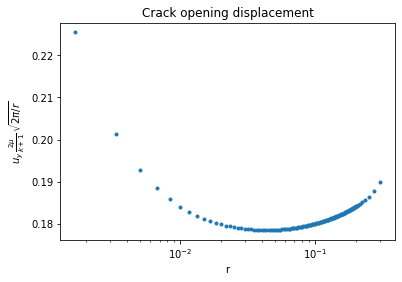

In [6]:
r = (Lcrack-xs)
r_ = r[np.where(xs<Lcrack)]
us_ = us[np.where(xs<Lcrack)]

kappa = (3 - elastic_solver.nu) / (1 + elastic_solver.nu)
factor = 2 * elastic_solver.mu / (kappa + 1)

plt.semilogx(r,us*np.sqrt(2*np.pi/r)*factor,".")
plt.xlabel("r")
plt.ylabel(r"${u_y} \,\frac{2\mu}{k+1} \,\sqrt{2\pi/r}$")
plt.title("Crack opening displacement")

We estimate $K_I\simeq 0.18$

## Stress at the crack tip

Let us get the stress around the crack tip

In [7]:
sigmah = elastic_solver.sigma(elastic_solver.eps(uh))
stress = dolfinx.Function(dolfinx.TensorFunctionSpace(mesh, ('DG', 0)), name="S")
project(sigmah,stress)
#plt.colorbar(dolfinx.plotting.plot(stress.sub(1),vmax=.3))
#plt.title(r"$\sigma_{xx}$")

Text(0.5, 1.0, 'Stress at the crack tip')

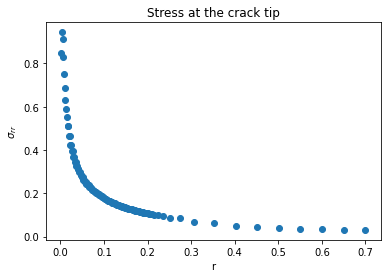

In [8]:
r = (xs-Lcrack)
stress_xx_bottom = stress.compute_point_values()[bottom_nodes,0][0]
r_ = r[np.where(xs>Lcrack)]
stress_xx = stress_xx_bottom[np.where(xs>Lcrack)]
plt.plot(r_,stress_xx,"o")
plt.xlabel("r")
plt.ylabel(r"$\sigma_{rr}$")
plt.title("Stress at the crack tip")

As detailed in the lectures notes, we can estimate the value of the stress intensity factor $K_I$ by extrapolating $\sigma_{rr} \sqrt{2\pi r}$

Text(0.5, 1.0, 'Stress at the crack tip')

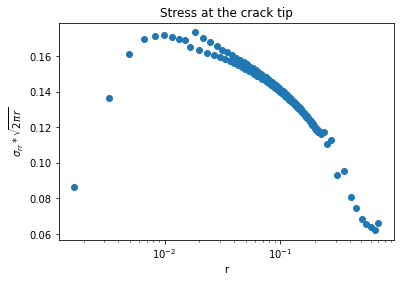

In [9]:
plt.semilogx(r_,stress_xx*np.sqrt(2*np.pi*r_),"o")
plt.xlabel("r")
plt.ylabel(r"$\sigma_{rr}*\sqrt{2\pi\,r}$")
plt.title("Stress at the crack tip")

We can say that $K_I\simeq 0.18$ as from the COD, but this estimate is not precise and reliable. 

From Irwing formula in plane-stress, we get the energy release rate (ERR)


In [10]:
KI_estimate = 0.18 #+-.02
G_estimate = KI_estimate ** 2 / elastic_solver.E # Irwin's formula in plane stress
print(f"ERR estimate is {G_estimate}")

ERR estimate is 0.0324


# The elastic energy release rate 

## Naïf method: finite difference of the potential energy

Let us first calculate the potential energy for several crack lengths. We multiply the result by 2 to account for the symmetry when comparing with the $K_I$ estimate above.

In [11]:
Ls = np.linspace(Lcrack*.7,Lcrack*1.3,10)
energies = np.zeros_like(Ls)
Gs = np.zeros_like(Ls)
for (i, L) in enumerate(Ls):
    uh, energies[i] = elastic_solver.solve_elasticity(Lx=1,Ly=.5,Lcrack=L,lc=.1,refinement_ratio=10,dist_min=.2,dist_max=.3)
    
energies = energies * 2

  return array(obj, copy=False)



Crack length: 2.100e-01 - Potential energy: -3.158e-03
Crack length: 2.300e-01 - Potential energy: -3.327e-03
Crack length: 2.500e-01 - Potential energy: -3.524e-03
Crack length: 2.700e-01 - Potential energy: -3.756e-03
Crack length: 2.900e-01 - Potential energy: -4.024e-03
Crack length: 3.100e-01 - Potential energy: -4.338e-03
Crack length: 3.300e-01 - Potential energy: -4.695e-03
Crack length: 3.500e-01 - Potential energy: -5.097e-03
Crack length: 3.700e-01 - Potential energy: -5.555e-03
Crack length: 3.900e-01 - Potential energy: -6.073e-03


We can estimate the ERR by taking the finite-difference approximation of the derivative

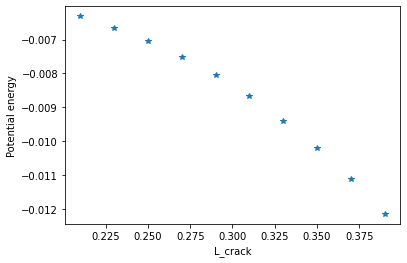

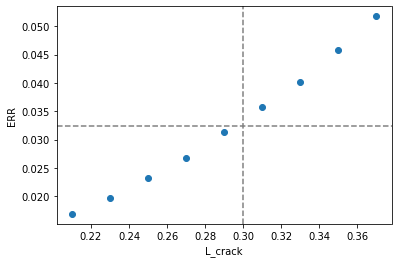

In [12]:
ERR_naif = -np.diff(energies)/np.diff(Ls)

plt.figure()
plt.plot(Ls, energies,"*")
plt.xlabel("L_crack")
plt.ylabel("Potential energy")
plt.figure()
plt.plot(Ls[0:-1], ERR_naif,"o")
plt.ylabel("ERR")
plt.xlabel("L_crack")
plt.axhline(G_estimate,linestyle='--',color="gray")
plt.axvline(Lcrack,linestyle='--',color="gray") 

## G-theta method: domain derivative

This function implement the G-theta method to compte the ERR as described in the lecture notes.

We first create by an auxiliary computation a suitable theta-field.

In [13]:
def create_theta_field(mesh,Lcrack,R_int=.1):
    
    element = ufl.FiniteElement('Lagrange',mesh.ufl_cell(),degree=1)   
    V0 = dolfinx.FunctionSpace(mesh, element)
    
    one = dolfinx.Function(V0)
    with one.vector.localForm() as one_loc:
        one_loc.set(1)
    
    zero = dolfinx.Function(V0)
    with zero.vector.localForm() as zero_loc:
        zero_loc.set(0)
    
    def inner_circle(x):
        return np.sqrt((x[0]-Lcrack)**2 + x[1]**2) < R_int 
    
    # Impose theta to 1 close to the tip
    facets = dolfinx.mesh.locate_entities(mesh, 1, inner_circle)
    dofs_inner = dolfinx.fem.locate_dofs_topological(V0, 1, facets)
    bc_inner = dolfinx.DirichletBC(one,dofs_inner)
    
    # Impose theta to vanish on the boundary         
    facets = dolfinx.mesh.locate_entities_boundary(mesh, 1, lambda x : x[1] > 0)
    dofs_outer = dolfinx.fem.locate_dofs_topological(V0, 1, facets)
    bc_out = dolfinx.DirichletBC(zero, dofs_outer)
    
    # bcs or theta
    bcs = [bc_out, bc_inner]
    
    # Define variational problem. We solve a simple laplacian
    theta, theta_ = ufl.TrialFunction(V0), ufl.TestFunction(V0)
    
    a = ufl.dot(ufl.grad(theta), ufl.grad(theta_)) * ufl.dx
    L = zero * theta_ * ufl.dx(domain=mesh) 
    
    problem = dolfinx.fem.LinearProblem(a, L, bcs=bcs, petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
    thetah = problem.solve()
    return thetah

uh, energy = elastic_solver.solve_elasticity(Lx=1,Ly=.5,Lcrack=.3,lc=.05,refinement_ratio=10,dist_min=.2,dist_max=.3)
#plt.figure()
#plt.colorbar(dolfinx.plotting.plot(uh,mode="displacement"),orientation="horizontal")
#plt.title("Solution of the elastic problem")

#plt.figure()
thetah = create_theta_field(uh.function_space.mesh,Lcrack=.3,R_int=.1)
#plt.colorbar(dolfinx.plotting.plot(thetah,vmin=0,vmax=1),orientation="horizontal")
#plt.title(r"$\theta$-field");

  return array(obj, copy=False)



Crack length: 3.000e-01 - Potential energy: -4.141e-03


From teh scalr field, we define a vector field by multiplying by the vector [1,0]

In [14]:
thetah_ = dolfinx.Function(uh.function_space)
project(thetah * ufl.as_vector([1,0]),thetah_)
#dolfinx.plotting.plot(thetah_,scale=10, title=r'Vector valued $\theta$-field')

Hence, we can compute the ERR with the formula

$$
G  = \int_\Omega \left(\sigma(\varepsilon(u))\cdot(\nabla u\nabla\theta)-\dfrac{1}{2}\sigma(\varepsilon(u))\cdot \varepsilon(u) \mathrm{div}(\theta)\,\right)\mathrm{dx}
$$

In [15]:
epsh_ = elastic_solver.eps(uh)
sigh_ = elastic_solver.sigma(epsh_)

first_term = ufl.inner(sigh_,ufl.grad(uh) * ufl.grad(thetah_)) * ufl.dx
second_term = - 0.5 * ufl.inner(sigh_,epsh_) * ufl.div(thetah_) * ufl.dx

G_theta = 2 * dolfinx.fem.assemble_scalar(first_term + second_term)
print(f'The ERR computed with the G-theta method is {G_theta:2.4f}' )

The ERR computed with the G-theta method is 0.0307


Interesting, as alternative, we can let `UFL` compute the symbolic derivative, and obtain the same result

In [16]:
# Define the energy with the change of variables
theta_ = dolfinx.Function(uh.function_space)
F = ufl.Identity(2) + ufl.grad(theta_)  # Gradient of transformation
eps_ = ufl.sym( ufl.grad(uh) * ufl.inv(F) )
P = 0.5 * ufl.inner(elastic_solver.sigma(eps_), eps_) * ufl.det(F) * ufl.dx

# Leaverage UFL to compute the symbolic derivative  
P_theta = ufl.derivative(P, theta_, thetah_)
G_theta_ufl = dolfinx.fem.assemble_scalar(-2*P_theta)
print(f'The ERR computed with the G-theta method is {G_theta_ufl:2.4f}' )

The ERR computed with the G-theta method is 0.0307


In [17]:
Ls = np.linspace(Lcrack*.7,Lcrack*1.3,10)
energies = np.zeros_like(Ls)
Gs = np.zeros_like(Ls)
for (i, L) in enumerate(Ls):
    uh, energies[i] = elastic_solver.solve_elasticity(Lx=1,Ly=.5,Lcrack=L,lc=.1,refinement_ratio=10,dist_min=.2,dist_max=.3)
    thetah = create_theta_field(uh.function_space.mesh,Lcrack=L,R_int=.1)
    thetah_ = thetah*ufl.as_vector([1,0])
    epsh_ = elastic_solver.eps(uh)
    sigh_ = elastic_solver.sigma(epsh_)
    first_term = ufl.inner(sigh_,ufl.grad(uh)*ufl.grad(thetah_))*ufl.dx
    second_term = - 0.5 * ufl.inner(sigh_,epsh_)*ufl.div(thetah_)*ufl.dx
    Gs[i] = 2*dolfinx.fem.assemble_scalar(first_term + second_term)
    # Save solution in XDMF format
    with dolfinx.io.XDMFFile(MPI.COMM_WORLD, "output/gtheta.xdmf", "w") as file:
        file.write_mesh(uh.function_space.mesh)
        #file.write_function(uh, L)        
        file.write_function(thetah, L)

Crack length: 2.100e-01 - Potential energy: -3.158e-03
Crack length: 2.300e-01 - Potential energy: -3.327e-03
Crack length: 2.500e-01 - Potential energy: -3.524e-03
Crack length: 2.700e-01 - Potential energy: -3.756e-03
Crack length: 2.900e-01 - Potential energy: -4.024e-03
Crack length: 3.100e-01 - Potential energy: -4.338e-03
Crack length: 3.300e-01 - Potential energy: -4.695e-03
Crack length: 3.500e-01 - Potential energy: -5.097e-03
Crack length: 3.700e-01 - Potential energy: -5.555e-03
Crack length: 3.900e-01 - Potential energy: -6.073e-03


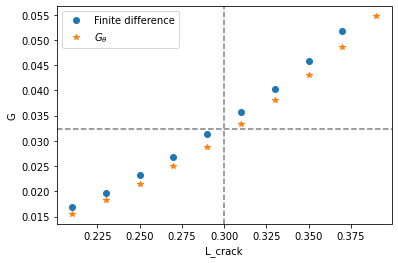

In [18]:
fig, ax = plt.subplots()
ax.plot(Ls[0:-1],ERR_naif,"o",label=r"Finite difference")
ax.plot(Ls,Gs,"*",label=r"$G_\theta$")
plt.xlabel("L_crack")
plt.ylabel("G")
plt.legend()
plt.axhline(G_estimate,linestyle='--',color="gray")
plt.axvline(Lcrack,linestyle='--',color="gray") 